In [1]:
%load_ext autoreload
%autoreload 2
%cd /mnt/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os
import logging
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from src.globals import *
from utils.visualization.show_image import show_image
from utils.register_datasets import register_datasets, get_dataset_name
from utils.config_builder import get_config
from utils.notebook_utils import *


from src.test import do_test
from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *
from src.active_learning.tta_sampler import *


logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())

/mnt/activeCell-ACDC
README.md					maps.txt
ac_acdc_env					nohup.out
acdc_large_cls_slim_coco_format.json.lock	notebooks
acdc_large_cls_test_slim_coco_format.json	output
acdc_large_cls_test_slim_coco_format.json.lock	pipeline_configs
al_output					requirements.txt
coco_instances_results.json			shell_scripts
data						src
instances_predictions.pth			uncertainties.csv
jupyter_notebooks				utils
log						wandb
maps-Copy1.txt


/mnt/activeCell-ACDC/ac_acdc_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = ACDC_LARGE_CLS
config_name = "classes_acdc_large_al"

model_path = "/mnt/activeCell-ACDC/al_output/classes_acdc_large_al/random"

In [3]:
register_datasets()
train_data = DatasetCatalog.get(get_dataset_name(
    dataset, DATASETS_DSPLITS[dataset][0]
))

test_data = DatasetCatalog.get("acdc_large_cls_test_slim")

registering acdc_large dataset
registering acdc_large_cls dataset


In [4]:
wandb.init(
    project="activeCell-ACDC",
    name="",
    sync_tensorboard=True,
    mode="disabled",
)

In [5]:
default_cfg = get_config(config_name)
cfg = default_cfg
cfg.OUTPUT_DIR = "./al_output/classes_acdc_large_al"
cfg.AL.OBJECT_TO_IMG_AGG = "mean"
cfg.AL.SAMPLE_EVERY = 60
cfg.TEST.DETECTIONS_PER_IMAGE = 100

In [6]:
mc_strategy = MCDropoutSampler(cfg)

mc_model = load_model(cfg, os.path.join(model_path, "best_model270.pth"))
#mc_model = patch_module(mc_model)

In [7]:
from detectron2.evaluation.coco_evaluation import *

class SingleImageCOCOEvaluator(COCOEvaluator):

    def __init__(
        self,
        dataset_name,
        tasks=None,
        distributed=True,
        output_dir=None,
        *,
        max_dets_per_image=None,
        use_fast_impl=True,
        kpt_oks_sigmas=(),
        allow_cached_coco=True,
    ) -> None:
        super().__init__(
            dataset_name=dataset_name,
            tasks=tasks,
            distributed=distributed,
            output_dir=output_dir,
            max_dets_per_image=max_dets_per_image,
            use_fast_impl=use_fast_impl,
            kpt_oks_sigmas=kpt_oks_sigmas,
            allow_cached_coco=kpt_oks_sigmas,
        )

        self.aps = {}
        
    def process(self, inputs, outputs):
        """
        Args:
            inputs: the inputs to a COCO model (e.g., GeneralizedRCNN).
                It is a list of dict. Each dict corresponds to an image and
                contains keys like "height", "width", "file_name", "image_id".
            outputs: the outputs of a COCO model. It is a list of dicts with key
                "instances" that contains :class:`Instances`.
        """
        for input, output in zip(inputs, outputs):
            prediction = {"image_id": input["image_id"]}

            if "instances" in output:
                instances = output["instances"].to(self._cpu_device)
                prediction["instances"] = instances_to_coco_json(instances, input["image_id"])
            if "proposals" in output:
                prediction["proposals"] = output["proposals"].to(self._cpu_device)
            if len(prediction) > 1:
                pred = [prediction]
                result = self.evaluate_single_img(pred, img_ids=[input["image_id"]])
                self.aps[input["image_id"]] = result
                

    def evaluate_single_img(self, pred, img_ids=None):
        """
        Args:
            img_ids: a list of image IDs to evaluate on. Default to None for the whole dataset
        """

        predictions = pred

        if len(predictions) == 0:
            self._logger.warning("[COCOEvaluator] Did not receive valid predictions.")
            return {}

        if self._output_dir:
            PathManager.mkdirs(self._output_dir)
            file_path = os.path.join(self._output_dir, "instances_predictions.pth")
            with PathManager.open(file_path, "wb") as f:
                torch.save(predictions, f)

        self._results = OrderedDict()
        if "proposals" in predictions[0]:
            self._eval_box_proposals(predictions)
        if "instances" in predictions[0]:
            self._eval_predictions(predictions, img_ids=img_ids)
        # Copy so the caller can do whatever with results
        return copy.deepcopy(self._results)
    
    def evaluate(self):
        return self.aps
        

In [35]:
evaluator = SingleImageCOCOEvaluator("acdc_large_cls_test_slim", cfg, False,output_dir="./" )
val_loader = build_detection_test_loader(cfg, "acdc_large_cls_test_slim")

#Use the created predicted model in the previous step
res = inference_on_dataset(mc_model, val_loader, evaluator)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.900
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.900
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50

In [39]:
res["TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0"]["bbox"]

{'AP': 90.0,
 'AP50': 100.0,
 'AP75': 100.0,
 'APs': 90.0,
 'APm': nan,
 'APl': nan,
 'AP-G1': nan,
 'AP-mother': 90.0,
 'AP-bud': 90.0}

In [8]:
def val2dicts(val):

    preds = []
    for v in val:
        pred_masks = v["pred_masks"].detach().cpu().numpy()
        pred_classes = v["pred_classes"].detach().cpu().numpy()

        preds.append({
            "pred_masks": pred_masks,
            "pred_classes": pred_classes,
        })

    return preds

def get_uncertainties(im_json, model, query_strategy):

    im = query_strategy.load_image(im_json)
    instance_list = query_strategy.get_samples(model, im, cfg.AL.NUM_MC_SAMPLES)
    combinded_instances = query_strategy.get_combinded_instances(instance_list)


    height, width = im.shape[:2]
    agg_uncertainty = query_strategy.get_uncertainty(combinded_instances, cfg.AL.NUM_MC_SAMPLES, height, width, mode=cfg.AL.OBJECT_TO_IMG_AGG)

    
    uncertainties = []

    for key, val in combinded_instances.items():

        val_len = torch.tensor(len(val)).to("cuda")

        if query_strategy.cfg.MODEL.ROI_HEADS.NUM_CLASSES > 1:
            u_sem = query_strategy.get_semantic_certainty(val, device = "cuda").detach().cpu().numpy()
        else:
            u_sem = 0
        u_mask = query_strategy.get_mask_certainty(val, height, width, val_len, device="cuda").detach().cpu().numpy()
        u_box = query_strategy.get_box_certainty(val, val_len, device="cuda").detach().cpu().numpy()
        u_det = query_strategy.get_detection_certainty(cfg.AL.NUM_MC_SAMPLES, val_len, device="cuda").detach().cpu().numpy()
        
        

        cpu_val = val2dicts(val)

        uncertainties.append({
            "val": cpu_val,
            "u_sem": u_sem,
            "u_mask": u_mask,
            "u_box": u_box,
            "u_det": u_det,

        })


    
    return uncertainties, agg_uncertainty

In [9]:
records_models = []

num_mc_samples = 20
print(num_mc_samples)
cfg_test = cfg
cfg_test.AL.NUM_MC_SAMPLES = num_mc_samples
mc_strategy = MCDropoutSampler(cfg_test)

dropout_prob = 0.5
cfg_test.MODEL.ROI_HEADS.DROPOUT_PROBABILITY = dropout_prob
cfg_test.MODEL.ROI_MASK_HEAD.DROPOUT_PROBABILITY = dropout_prob
cfg_test.MODEL.ROI_BOX_HEAD.DROPOUT_PROBABILITY = dropout_prob


num_train_data = 270


cfg_test = cfg


mc_strategy = MCDropoutSampler(cfg_test)
mc_model = load_model(cfg_test, os.path.join(model_path, f"best_model{str(num_train_data)}.pth"))
mc_model = patch_module(mc_model)
for im_json in tqdm(test_data):
    uncertainties, agg_uncertainty = get_uncertainties(im_json, mc_model, mc_strategy)
    records_models.append({
        "num_mc_samples": num_mc_samples,
        "model_train_size": num_train_data,
        "image_id": im_json["image_id"],
        "agg_uncertainty": agg_uncertainty,
        #"uncertainties": uncertainties,
    })

20


  0%|                                                                                                                                                                                                                 | 0/509 [00:00<?, ?it/s]/mnt/activeCell-ACDC/ac_acdc_env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 509/509 [2:04:53<00:00, 14.72s/it]


In [12]:
records_models

df = pd.DataFrame.from_records(records_models)
df.to_csv("uncertainties.csv")

In [ ]:
res

import json

with open("maps.txt", "w") as fp:
    json.dump(person, fp)  # encode dict into JSON
print("Done writing dict into .txt file")

In [13]:
df = pd.read_csv("uncertainties.csv")

In [15]:
with open("maps-Copy1.txt","r") as fp:
    res = json.loads(fp.read())
 

In [23]:
maps_df = pd.DataFrame.from_records([
    {
        "image_id": key,
        "segm_ap": res[key]["segm"]["AP"]
    }
    for key in res.keys()
])

In [24]:
maps_df.head()

,image_id,segm_ap
0,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,95.000000
1,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,92.120462
2,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,94.620462
3,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,90.726073
4,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,69.449945


In [25]:
df.head()

,Unnamed: 0,num_mc_samples,model_train_size,image_id,agg_uncertainty
0,0,20,270,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,0.000000
1,1,20,270,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,0.120735
2,2,20,270,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,0.084379
3,3,20,270,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,0.142778
4,4,20,270,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,0.084592


In [26]:
merge_df = pd.merge(df, maps_df, how='inner', on = 'image_id')

In [27]:
merge_df.head()

,Unnamed: 0,num_mc_samples,model_train_size,image_id,agg_uncertainty,segm_ap
0,0,20,270,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,0.000000,95.000000
1,1,20,270,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,0.120735,92.120462
2,2,20,270,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,0.084379,94.620462
3,3,20,270,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,0.142778,90.726073
4,4,20,270,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,0.084592,69.449945


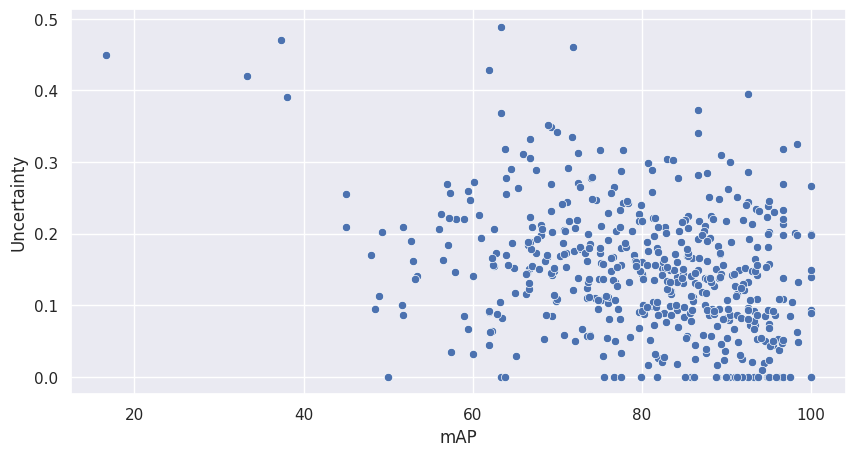

In [28]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.scatterplot(data=merge_df, x="segm_ap", y="agg_uncertainty")
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("mAP")
plt.ylabel("Uncertainty")
#plt.title(f'Experiment: {exp}')
plt.show()

                       segm_ap  agg_uncertainty_scale
segm_ap                 1.0000                -0.3367
agg_uncertainty_scale  -0.3367                 1.0000


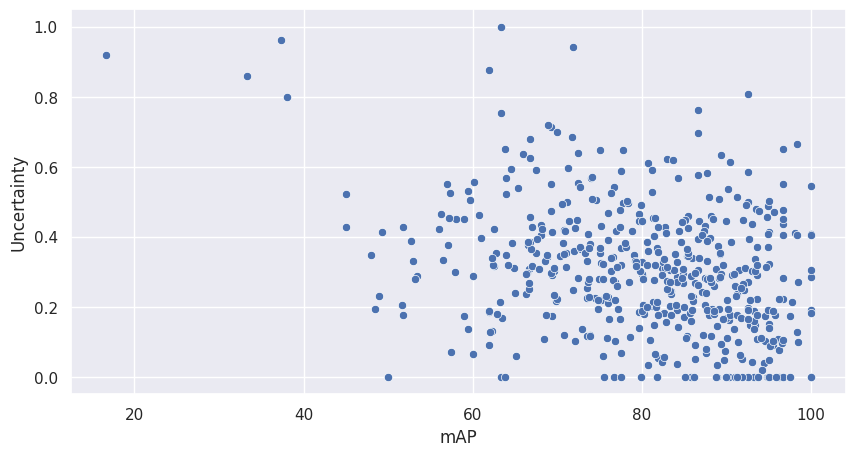

In [29]:
merge_df["agg_uncertainty_scale"] = merge_df["agg_uncertainty"]/merge_df["agg_uncertainty"].max()

print(merge_df[["segm_ap","agg_uncertainty_scale"]].corr())

sns.set(rc={"figure.figsize":(10, 5)})
sns.scatterplot(data=merge_df, x="segm_ap", y="agg_uncertainty_scale")
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("mAP")
plt.ylabel("Uncertainty")
#plt.title(f'Experiment: {exp}')
plt.show()

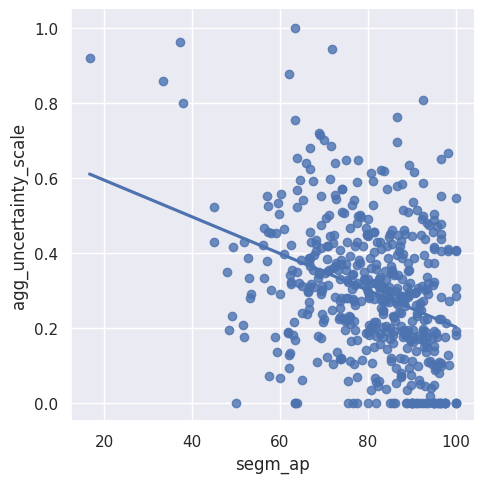

In [30]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lmplot(x="segm_ap", y="agg_uncertainty_scale", data=merge_df, ci=None);